# Statistical Analysis <a id='stats'></a>

[Data quality](#qa) <br>
[Behavioral results](#beh) <br>
[Brain graph metrics](#graph) <br>
[Mean FC](#fc) <br>
[Regression analyses](#reg) <br>

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pingouin as pg

pd.set_option("display.precision", 3)
sns.set_palette('Set1')

homeDir = os.path.expanduser("~")
homeDir

'/Users/mcmahonmc'

In [2]:
df = pd.read_csv('./data/03_fc_data.csv')
df = df.set_index('subject')
print(df.shape)


modVars = [col for col in df.columns if col.startswith('q_')]
pcVars = [i for i in df.columns if 'pc_' in i and 'dmn_fpn' not in i]
fcVars = [col for col in df.columns if 'fc' in col]
memVars = [col for col in df.columns if 'acc_' in col or 'rt_c_' in col]
edgeVars = [col for col in df if col.startswith('net')]
pcaVars = ['C1', 'C2', 'C3']
sleepVars = ['actamp', 'actphi', 'sleep_time_mean_sleep', 'total_ac_mean_active', 'efficiency_mean_sleep']

df.head()

(130, 92)


/usr/local/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


,Group,GroupBin,age,sex,acc_learning,rt_c_learning,acc_learning_log,acc_test_mean,rt_c_test_mean,acc_test_std,...,net_int_edge_19,net_int_edge_20,net_int_edge_21,net_int_edge_22,net_int_edge_23,net_int_edge_24,net_int_mean,C1,C2,C3
subject,,,,,,,,,,,,,,,,,,,,,
30003,Young Adults,0,22.0,Female,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30004,Young Adults,0,27.0,Female,0.917,1263.611,-0.038,0.972,11297.879,0.048,...,0.902,0.518,0.265,0.079,0.082,0.034,0.166,0.168,-0.199,-0.113
30008,Young Adults,0,18.0,Female,0.944,1674.861,-0.025,0.944,11504.639,0.048,...,0.350,-0.051,0.715,0.176,0.100,0.201,0.185,0.020,0.117,-0.165
30009,Young Adults,0,25.0,Female,0.972,1568.694,-0.012,0.972,11405.333,0.048,...,0.247,0.266,0.087,0.601,0.353,0.064,0.096,0.975,-0.306,0.100
30012,Young Adults,0,30.0,Male,0.917,2146.417,-0.038,0.806,11539.750,0.127,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.820,-0.199,-0.186


## Data quality <a id='qa'></a>

In [3]:
print(df.shape)
df = df.dropna(subset=['acc_test_mean'])
print(df.shape)
# df = df[(df['acc_learning'] > 0.33)]
# print(df.shape)
df = df[(df['acc_test_mean'] > 0.56)]
print(df.shape)

(130, 92)
(114, 92)
(101, 92)


In [4]:
df.isna().sum()

Group               0
GroupBin            0
age                 0
sex                 0
acc_learning        0
                   ..
net_int_edge_24    27
net_int_mean       27
C1                  8
C2                  8
C3                  8
Length: 92, dtype: int64

In [5]:
df[df['Group'] == 'Older Adults'].isna().sum()

Group               0
GroupBin            0
age                 0
sex                 0
acc_learning        0
                   ..
net_int_edge_24    22
net_int_mean       22
C1                  5
C2                  5
C3                  5
Length: 92, dtype: int64

In [6]:
ya = df[df['Group'] == 'Young Adults']
ya = ya.fillna(ya.mean())

oa = df[df['Group'] == 'Older Adults']
oa = oa.fillna(oa.mean())

dfFill = pd.concat((ya, oa))
print(df.shape)
dfFill.head()

/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_49729/852004413.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ya = ya.fillna(ya.mean())


(101, 92)


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_49729/852004413.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  oa = oa.fillna(oa.mean())


,Group,GroupBin,age,sex,acc_learning,rt_c_learning,acc_learning_log,acc_test_mean,rt_c_test_mean,acc_test_std,...,net_int_edge_19,net_int_edge_20,net_int_edge_21,net_int_edge_22,net_int_edge_23,net_int_edge_24,net_int_mean,C1,C2,C3
subject,,,,,,,,,,,,,,,,,,,,,
30004,Young Adults,0,27.0,Female,0.917,1263.611,-0.038,0.972,11297.879,0.048,...,0.902,0.518,0.265,0.079,0.082,0.034,0.166,0.168,-0.199,-0.113
30008,Young Adults,0,18.0,Female,0.944,1674.861,-0.025,0.944,11504.639,0.048,...,0.350,-0.051,0.715,0.176,0.100,0.201,0.185,0.020,0.117,-0.165
30009,Young Adults,0,25.0,Female,0.972,1568.694,-0.012,0.972,11405.333,0.048,...,0.247,0.266,0.087,0.601,0.353,0.064,0.096,0.975,-0.306,0.100
30012,Young Adults,0,30.0,Male,0.917,2146.417,-0.038,0.806,11539.750,0.127,...,0.460,0.290,0.299,0.230,0.338,0.224,0.198,0.820,-0.199,-0.186
30015,Young Adults,0,26.0,Male,0.972,2064.250,-0.012,0.889,11690.604,0.048,...,0.170,0.281,-0.048,0.396,0.034,0.199,0.149,0.160,-0.288,0.026


In [7]:
df.acc_test_mean.min()

0.638888888888889

## Behavioral results <a id='beh'></a>

### Task

In [8]:
behtable = df[['Group'] + [c for c in memVars if 'mean' in c]].groupby('Group').describe().T.round(3)[['Young Adults', 'Older Adults']]
behtable.to_latex('./results/behresults.tex', index=True)
behtable

Group                    Young Adults  Older Adults
acc_test_mean     count        50.000        51.000
                  mean          0.904         0.844
                  std           0.098         0.095
                  min           0.667         0.639
                  25%           0.861         0.778
                  50%           0.944         0.861
                  75%           0.972         0.917
                  max           1.000         1.000
rt_c_test_mean    count        50.000        51.000
                  mean      11492.862     11793.581
                  std         204.527       242.235
                  min       11063.972     11210.629
                  25%       11327.306     11625.181
                  50%       11488.197     11799.460
                  75%       11616.986     11937.344
                  max       11955.700     12314.625
acc_test_mean_log count        50.000        51.000
                  mean         -0.047        -0.076
                  std           0.051         0.050
                  min          -0.176        -0.195
                  25%          -0.065        -0.109
                  50%          -0.025        -0.065
                  75%          -0.012        -0.038
                  max           0.000         0.000

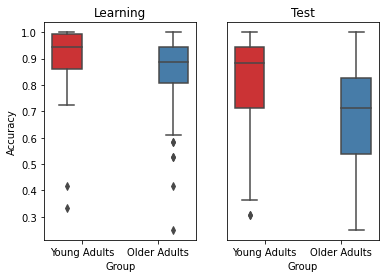

In [9]:
sns.set_palette('Set1')
fig, axes = plt.subplots(1,2)

sns.boxplot(data=df, x='Group', y='acc_learning', hue='Group', ax=axes[0]).set(title='Learning');
axes[0].set_ylabel('Accuracy'); axes[0].get_legend().remove()

sns.boxplot(data=df, x='Group', y='acc_test_mean', hue='Group', ax=axes[1]).set(title='Test');
plt.ylabel(''); axes[1].yaxis.set_visible(False); axes[1].get_legend().remove()
plt.savefig('./results/accuracy.png', dpi=300)

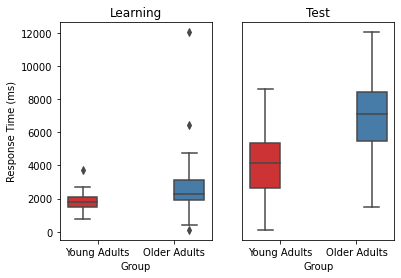

In [10]:
sns.set_palette('Set1')
fig, axes = plt.subplots(1,2)

sns.boxplot(data=df, x='Group', y='rt_c_learning', hue='Group', ax=axes[0]).set(title='Learning');
axes[0].set_ylabel('Response Time (ms)'); axes[0].get_legend().remove()

sns.boxplot(data=df, x='Group', y='rt_c_test_mean', hue='Group', ax=axes[1]).set(title='Test');
plt.ylabel(''); axes[1].yaxis.set_visible(False); axes[1].get_legend().remove()
plt.savefig('./results/rtc.png', dpi=300)

In [11]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['acc_learning'].dropna(), df[df['Group'] == "Older Adults"]['acc_learning'].dropna())

Ttest_indResult(statistic=2.4143132260486198, pvalue=0.017601659772950102)

In [12]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['rt_c_learning'].dropna(), df[df['Group'] == "Older Adults"]['rt_c_learning'].dropna())

Ttest_indResult(statistic=-3.4868986692939816, pvalue=0.0007302456293783779)

In [13]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['acc_test_mean'].dropna(), df[df['Group'] == "Older Adults"]['acc_test_mean'].dropna())

Ttest_indResult(statistic=3.07098105962096, pvalue=0.0027545413222601154)

In [14]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['rt_c_test_mean'].dropna(), df[df['Group'] == "Older Adults"]['rt_c_test_mean'].dropna())

Ttest_indResult(statistic=-6.734662438907178, pvalue=1.0900781187648063e-09)

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='acc_learning_log', ylabel='Density'>

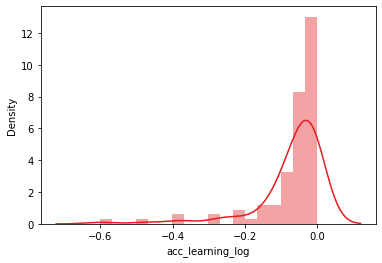

In [15]:
sns.distplot(df['acc_learning_log'].dropna())

### RAR/Sleep

In [16]:
stats.ttest_ind(df[df['sex'] == "Male"]['actamp'].dropna(), df[df['sex'] == "Female"]['actamp'].dropna())

Ttest_indResult(statistic=-1.2552434838834525, pvalue=0.21256941350539846)

In [17]:
stats.ttest_ind(df[df['sex'] == "Male"]['actphi'].dropna(), df[df['sex'] == "Female"]['actphi'].dropna())

Ttest_indResult(statistic=0.5407827913228753, pvalue=0.5899364935942184)

In [18]:
pg.corr(df['actamp'], df['sleep_time_mean_sleep'])

,n,r,CI95%,p-val,BF10,power
pearson,94,0.049,"[-0.15, 0.25]",0.636,0.144,0.076


In [19]:
pg.corr(df['actamp'], df['efficiency_mean_sleep'])

,n,r,CI95%,p-val,BF10,power
pearson,94,0.279,"[0.08, 0.46]",0.006,5.028,0.786


In [20]:
pg.corr(df['actamp'], df['total_ac_mean_active'])

,n,r,CI95%,p-val,BF10,power
pearson,94,0.293,"[0.1, 0.47]",0.004,7.31,0.824


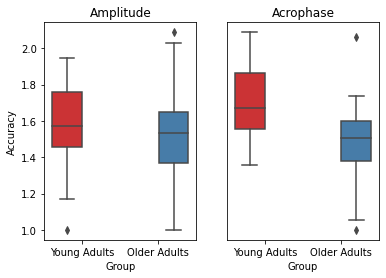

In [21]:
sns.set_palette('Set1')
fig, axes = plt.subplots(1,2)

sns.boxplot(data=df, x='Group', y='actamp', hue='Group', ax=axes[0]).set(title='Amplitude');
axes[0].set_ylabel('Accuracy'); axes[0].get_legend().remove()

sns.boxplot(data=df, x='Group', y='actphi', hue='Group', ax=axes[1]).set(title='Acrophase');
plt.ylabel(''); axes[1].yaxis.set_visible(False); axes[1].get_legend().remove()
plt.savefig('./results/rar.png', dpi=300)

In [22]:
df[['actamp', 'actphi', 'sleep_time_mean_sleep', 'total_ac_mean_active', 'efficiency_mean_sleep', 'Group']].groupby('Group').mean().T

Group,Older Adults,Young Adults
actamp,1.533,1.597
actphi,14.825,16.438
sleep_time_mean_sleep,399.031,388.256
total_ac_mean_active,259328.830,295772.503
efficiency_mean_sleep,79.210,81.672


In [23]:
df[['actamp', 'actphi', 'sleep_time_mean_sleep', 'total_ac_mean_active', 'efficiency_mean_sleep', 'Group']].groupby('Group').std().T

Group,Older Adults,Young Adults
actamp,0.253,0.215
actphi,1.462,1.459
sleep_time_mean_sleep,86.001,60.026
total_ac_mean_active,92699.886,107708.657
efficiency_mean_sleep,9.242,6.332


In [24]:
var='actamp'
stats.ttest_ind(df[df['Group'] == "Young Adults"][var].dropna(), df[df['Group'] == "Older Adults"][var].dropna())

Ttest_indResult(statistic=1.3252264240552305, pvalue=0.18837785821504685)

In [25]:
var='actphi'
stats.ttest_ind(df[df['Group'] == "Young Adults"][var].dropna(), df[df['Group'] == "Older Adults"][var].dropna())

Ttest_indResult(statistic=5.410157624405946, pvalue=4.782842167566509e-07)

In [26]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['sleep_time_mean_sleep'].dropna(), df[df['Group'] == "Older Adults"]['sleep_time_mean_sleep'].dropna())


Ttest_indResult(statistic=-0.7142595671851596, pvalue=0.4768366238552493)

In [27]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['total_ac_mean_active'].dropna(), df[df['Group'] == "Older Adults"]['total_ac_mean_active'].dropna())



Ttest_indResult(statistic=1.7735592232458697, pvalue=0.07937463643790361)

In [28]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['efficiency_mean_sleep'].dropna(), df[df['Group'] == "Older Adults"]['efficiency_mean_sleep'].dropna())

Ttest_indResult(statistic=1.527838698683831, pvalue=0.12991067116478924)

## Global brain network metrics <a id='graph'></a>

In [29]:
df[['q_dmnfpn_cue', 'q_dmnfpn_rest', 'pc_dmnfpn_cue', 'q_global_cue', 'q_global_rest', 'pc_global_cue', 'Group']].groupby('Group').mean().T

Group,Older Adults,Young Adults
q_dmnfpn_cue,0.142,0.147
q_dmnfpn_rest,0.144,0.121
pc_dmnfpn_cue,0.215,0.186
q_global_cue,0.304,0.365
q_global_rest,0.368,0.373
pc_global_cue,0.417,0.413


In [30]:
df[['Group'] + fcVars].groupby('Group').mean().T

Group,Older Adults,Young Adults
hc_dmn_fc,0.248,0.200
hc_fpn_fc,0.195,0.091
dmn_fpn_fc,0.292,0.222
dmn_fc,0.371,0.339
fpn_fc,0.483,0.435


In [31]:
var = 'hc_dmn_fc'
stats.ttest_ind(df[df['Group'] == "Young Adults"][var].dropna(), df[df['Group'] == "Older Adults"][var].dropna())

Ttest_indResult(statistic=-1.4336777356582002, pvalue=0.15599284187064164)

In [32]:
var = 'hc_fpn_fc'
stats.ttest_ind(df[df['Group'] == "Young Adults"][var].dropna(), df[df['Group'] == "Older Adults"][var].dropna())

Ttest_indResult(statistic=-2.8365920723681977, pvalue=0.005917492092503616)

In [33]:
var = 'dmn_fpn_fc'
stats.ttest_ind(df[df['Group'] == "Young Adults"][var].dropna(), df[df['Group'] == "Older Adults"][var].dropna())

Ttest_indResult(statistic=-2.1556085897349346, pvalue=0.034457360263872513)

In [34]:
var = 'dmn_fc'
stats.ttest_ind(df[df['Group'] == "Young Adults"][var].dropna(), df[df['Group'] == "Older Adults"][var].dropna())

Ttest_indResult(statistic=-1.214730615331837, pvalue=0.22843765020373202)

In [35]:
var = 'fpn_fc'
stats.ttest_ind(df[df['Group'] == "Young Adults"][var].dropna(), df[df['Group'] == "Older Adults"][var].dropna())

Ttest_indResult(statistic=-1.5566603545060897, pvalue=0.12393612671733144)

In [36]:

stats.ttest_ind(df[df['Group'] == "Young Adults"]['q_dmnfpn_rest'].dropna(), df[df['Group'] == "Older Adults"]['q_dmnfpn_rest'].dropna())

Ttest_indResult(statistic=-1.785224591111795, pvalue=0.07889044601975033)

In [37]:

stats.ttest_ind(df[df['Group'] == "Young Adults"]['pc_dmnfpn_cue'].dropna(), df[df['Group'] == "Older Adults"]['pc_dmnfpn_cue'].dropna())

Ttest_indResult(statistic=-2.4759275560412495, pvalue=0.01564144274922783)

In [38]:

stats.ttest_ind(df[df['Group'] == "Young Adults"]['q_global_cue'].dropna(), df[df['Group'] == "Older Adults"]['q_global_cue'].dropna())

Ttest_indResult(statistic=4.886028590236158, pvalue=6.029740825391916e-06)

In [39]:
dfl = df.reset_index()[['subject', 'Group'] + modVars]
dfl = pd.wide_to_long(dfl, ["q_global", 'q_power', "q_dmnfpn"], i=['subject', 'Group'], j="condition", sep='_', suffix=r'\w+')
dfl = dfl.reset_index()
dfl

,subject,Group,condition,q_global,q_power,q_dmnfpn
0,30004,Young Adults,cue,0.398,0.398,0.242
1,30004,Young Adults,diff,0.015,NaN,-0.054
2,30004,Young Adults,match,0.382,0.382,0.158
3,30004,Young Adults,mismatch,0.301,0.301,0.179
4,30004,Young Adults,rest,0.413,NaN,0.188
...,...,...,...,...,...,...
500,40968,Older Adults,cue,0.346,0.346,0.207
501,40968,Older Adults,diff,NaN,NaN,NaN
502,40968,Older Adults,match,0.256,0.256,0.073
503,40968,Older Adults,mismatch,0.326,0.326,0.101


Text(0.5, 0, 'Condition')

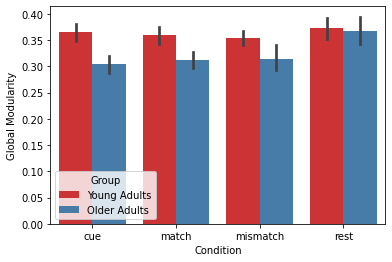

In [40]:
dfp = dfl[dfl['condition'] != 'diff']
sns.barplot(x=dfp['condition'], y=dfp['q_global'], hue=dfp['Group'])
plt.ylabel('Global Modularity'); plt.xlabel('Condition')

Text(0.5, 0, 'Condition')

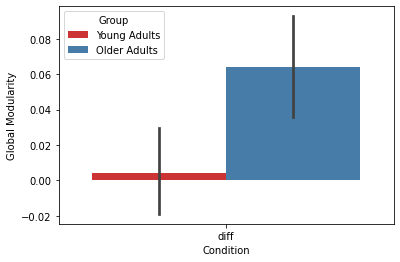

In [41]:
dfp = dfl[dfl['condition'] == 'diff']
sns.barplot(x=dfp['condition'], y=dfp['q_global'], hue=dfp['Group'])
plt.ylabel('Global Modularity'); plt.xlabel('Condition')

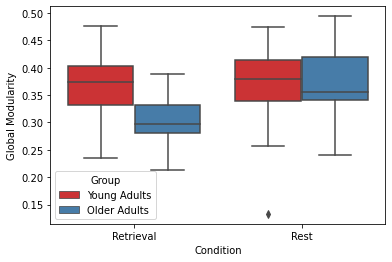

In [42]:
dfbar = dfl[(dfl['condition'].isin(['rest', 'cue']))]
ax = sns.boxplot(x=dfbar['condition'], y=dfbar['q_global'], hue=dfbar['Group'])
plt.ylabel('Global Modularity'); plt.xlabel('Condition')
ax.set_xticklabels(['Retrieval', 'Rest'])
plt.savefig('./results/globalmod_cond.png', dpi=300)

Text(0.5, 0, 'Condition')

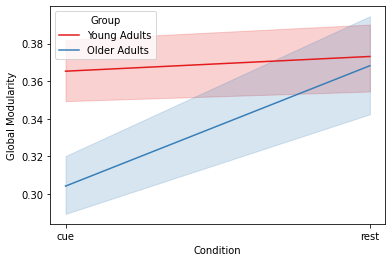

In [43]:
dfbar = dfl[(dfl['condition'].isin(['rest', 'cue']))]
sns.lineplot(x=dfbar['condition'], y=dfbar['q_global'], hue=dfbar['Group'])
plt.ylabel('Global Modularity'); plt.xlabel('Condition')

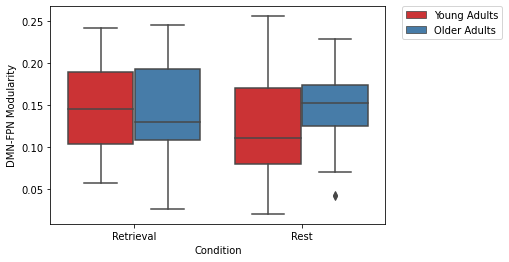

In [44]:
dfbar = dfl[(dfl['condition'].isin(['rest', 'cue']))]
ax = sns.boxplot(x=dfbar['condition'], y=dfbar['q_dmnfpn'], hue=dfbar['Group'])
plt.ylabel('DMN-FPN Modularity'); plt.xlabel('Condition')
ax.set_xticklabels(['Retrieval', 'Rest'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.savefig('./results/dmnfpnmod_cond.png', dpi=300)

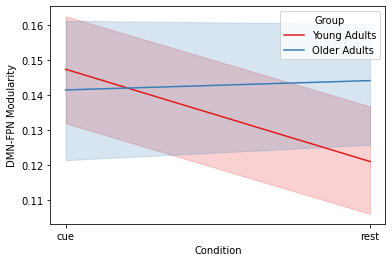

In [45]:
dfbar = dfl[(dfl['condition'].isin(['rest', 'cue']))]
sns.lineplot(x=dfbar['condition'], y=dfbar['q_dmnfpn'], hue=dfbar['Group'])
plt.ylabel('DMN-FPN Modularity'); plt.xlabel('Condition');

DMN-FPN Modularity

In [46]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['q_dmnfpn_rest'].dropna(), df[df['Group'] == "Older Adults"]['q_dmnfpn_rest'].dropna())

Ttest_indResult(statistic=-1.785224591111795, pvalue=0.07889044601975033)

In [47]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['q_dmnfpn_rest'].dropna(), df[df['Group'] == "Young Adults"]['q_dmnfpn_cue'].dropna())

Ttest_indResult(statistic=-2.3092812095903357, pvalue=0.02341318923769706)

Global modularity

In [48]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['q_dmnfpn_cue'].dropna(), df[df['Group'] == "Older Adults"]['q_dmnfpn_cue'].dropna())

Ttest_indResult(statistic=0.4705602407546608, pvalue=0.6394177745058853)

In [49]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['q_global_rest'].dropna(), df[df['Group'] == "Young Adults"]['q_global_cue'].dropna())

Ttest_indResult(statistic=0.6114374682475329, pvalue=0.5425418649538385)

In [50]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Older Adults"]['q_global_rest'].dropna(), df[df['Group'] == "Older Adults"]['q_global_cue'].dropna())

Ttest_indResult(statistic=4.136927134579034, pvalue=0.00012897991576189073)

In [51]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Older Adults"]['q_dmnfpn_rest'].dropna(), df[df['Group'] == "Older Adults"]['q_dmnfpn_cue'].dropna())

Ttest_indResult(statistic=0.19381733048399608, pvalue=0.847074060088742)

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


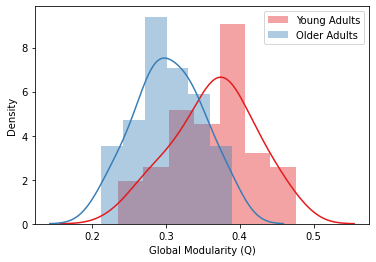

In [52]:
sns.distplot(df[df['Group'] == "Young Adults"]['q_global_cue'].dropna(), label = 'Young Adults')
sns.distplot(df[df['Group'] == "Older Adults"]['q_global_cue'].dropna(), label = 'Older Adults')
plt.xlabel('Global Modularity (Q)')
plt.legend()
plt.savefig('./results/global_modularity.png', dpi=300)

In [53]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['q_global_cue'].dropna(), df[df['Group'] == "Older Adults"]['q_global_cue'].dropna())

Ttest_indResult(statistic=4.886028590236158, pvalue=6.029740825391916e-06)

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


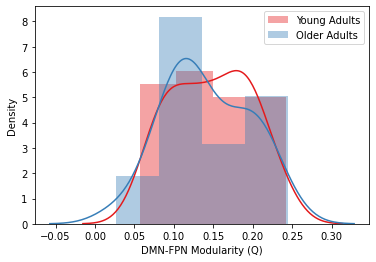

In [54]:
sns.distplot(df[df['Group'] == "Young Adults"]['q_dmnfpn_cue'].dropna(), label = 'Young Adults')
sns.distplot(df[df['Group'] == "Older Adults"]['q_dmnfpn_cue'].dropna(), label = 'Older Adults')
plt.xlabel('DMN-FPN Modularity (Q)')
plt.legend()

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


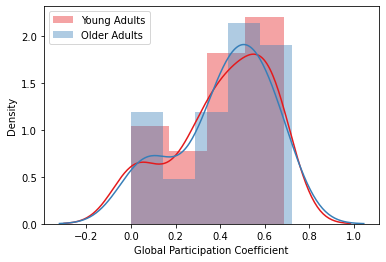

In [55]:
sns.distplot(df[df['Group'] == "Young Adults"]['pc_global_cue'].dropna(), label = 'Young Adults')
sns.distplot(df[df['Group'] == "Older Adults"]['pc_global_cue'].dropna(), label = 'Older Adults')
plt.xlabel('Global Participation Coefficient')
plt.legend()
plt.savefig('./results/global_pc.png', dpi=300)

In [56]:
dfl = df.reset_index()[['subject', 'Group'] + pcVars[2:]]
dfl = pd.wide_to_long(dfl, ['pc_global', 'pc_dmn', 'pc_fpn', 'pc_dmnfpn'], i=['subject', 'Group'], j="condition", sep='_', suffix=r'\w+')
dfl = dfl.reset_index()
dfl

,subject,Group,condition,pc_power_mismatch,pc_power_match,pc_power_cue,pc_global,pc_dmn,pc_fpn,pc_dmnfpn
0,30004,Young Adults,cue,0.281,0.572,0.421,NaN,0.439,0.293,0.132
1,30004,Young Adults,match,0.281,0.572,0.421,NaN,0.414,0.413,0.185
2,30004,Young Adults,mismatch,0.281,0.572,0.421,0.281,0.161,0.358,0.191
3,30008,Young Adults,cue,0.636,0.069,0.670,NaN,0.432,0.289,0.152
4,30008,Young Adults,match,0.636,0.069,0.670,NaN,0.333,0.447,0.182
...,...,...,...,...,...,...,...,...,...,...
298,40930,Older Adults,match,NaN,NaN,NaN,NaN,NaN,NaN,NaN
299,40930,Older Adults,mismatch,NaN,NaN,NaN,NaN,NaN,NaN,NaN
300,40968,Older Adults,cue,0.635,0.663,0.536,NaN,0.445,0.452,0.167
301,40968,Older Adults,match,0.635,0.663,0.536,NaN,0.511,0.551,0.275


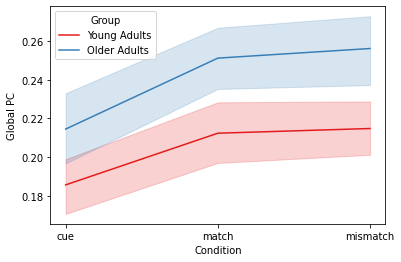

In [57]:
sns.lineplot(x=dfl['condition'], y=dfl['pc_dmnfpn'], hue=dfl['Group'])
plt.ylabel('Global PC'); plt.xlabel('Condition');

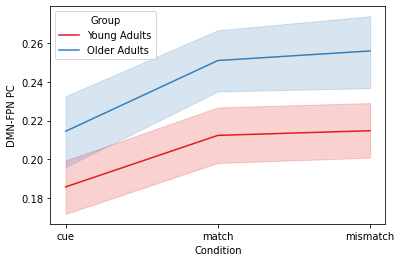

In [58]:
sns.lineplot(x=dfl['condition'], y=dfl['pc_dmnfpn'], hue=dfl['Group'])
plt.ylabel('DMN-FPN PC'); plt.xlabel('Condition');

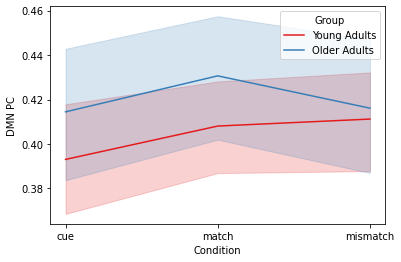

In [59]:
sns.lineplot(x=dfl['condition'], y=dfl['pc_dmn'], hue=dfl['Group'])
plt.ylabel('DMN PC'); plt.xlabel('Condition');

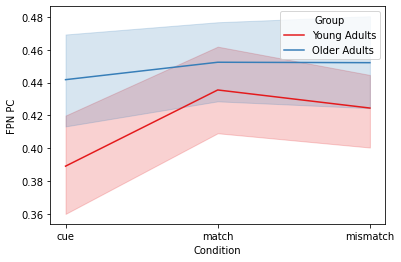

In [60]:
sns.lineplot(x=dfl['condition'], y=dfl['pc_fpn'], hue=dfl['Group'])
plt.ylabel('FPN PC'); plt.xlabel('Condition');

## Mean FC <a id='fc'></a>

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


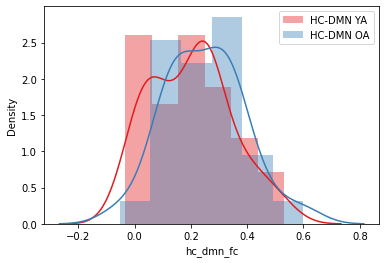

In [61]:
sns.distplot(df[df['Group'] == "Young Adults"]['hc_dmn_fc'], label = 'HC-DMN YA')
sns.distplot(df[df['Group'] == "Older Adults"]['hc_dmn_fc'], label = 'HC-DMN OA')
plt.legend()

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


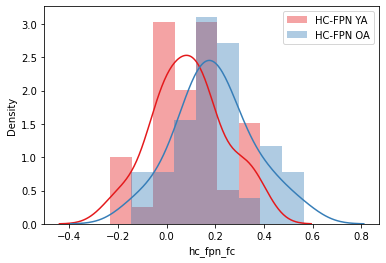

In [62]:
sns.distplot(df[df['Group'] == "Young Adults"]['hc_fpn_fc'], label = 'HC-FPN YA')
sns.distplot(df[df['Group'] == "Older Adults"]['hc_fpn_fc'], label = 'HC-FPN OA')
plt.legend()

In [63]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['hc_fpn_fc'].dropna(), df[df['Group'] == "Older Adults"]['hc_fpn_fc'].dropna(), equal_var=True)

Ttest_indResult(statistic=-2.8365920723681977, pvalue=0.005917492092503616)

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


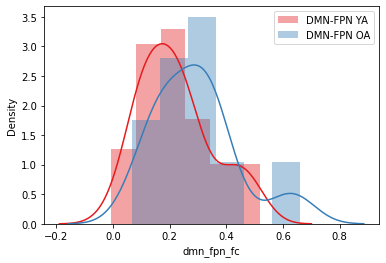

In [64]:
sns.distplot(df[df['Group'] == "Young Adults"]['dmn_fpn_fc'], label = 'DMN-FPN YA')
sns.distplot(df[df['Group'] == "Older Adults"]['dmn_fpn_fc'], label = 'DMN-FPN OA')
plt.legend()

In [65]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['dmn_fpn_fc'], df[df['Group'] == "Older Adults"]['dmn_fpn_fc'], equal_var=True)

Ttest_indResult(statistic=nan, pvalue=nan)

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


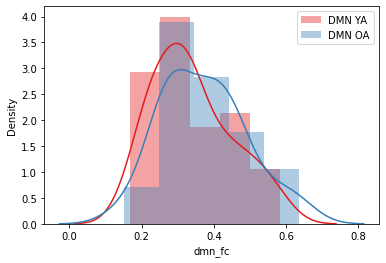

In [66]:
sns.distplot(df[df['Group'] == "Young Adults"]['dmn_fc'], label = 'DMN YA')
sns.distplot(df[df['Group'] == "Older Adults"]['dmn_fc'], label = 'DMN OA')
plt.legend()

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


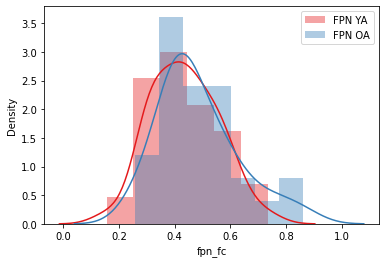

In [67]:
sns.distplot(df[df['Group'] == "Young Adults"]['fpn_fc'], label = 'FPN YA')
sns.distplot(df[df['Group'] == "Older Adults"]['fpn_fc'], label = 'FPN OA')
plt.legend()

## Regression analyses <a id='reg'></a>

In [68]:
from scipy.stats.mstats import zscore

convert_dict = {'Group': str,
                'sex': str
               }
  
df = df.astype(convert_dict)

print(df.shape)

(101, 92)


In [69]:
# ya = ya.select_dtypes(include=object).join(ya.select_dtypes(include=[np.number]).apply(stats.zscore))
# abs_z_scores = ya.select_dtypes(include=[np.number]).abs()
# filtered_entries = (abs_z_scores < 3).all(axis=1)
# yaCl = ya[filtered_entries]
# yaCl.shape

In [70]:
# oa = oa.select_dtypes(include=object).join(oa.select_dtypes(include=[np.number]).apply(stats.zscore))
# abs_z_scores = oa.select_dtypes(include=[np.number]).abs()
# filtered_entries = (abs_z_scores < 3).all(axis=1)
# oaCl = oa[filtered_entries]
# oaCl.shape

In [71]:
df.groupby(['Group'])['age', 'hc_dmn_fc', 'hc_fpn_fc', 'q_global_cue'].describe()

/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_49729/3237840119.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby(['Group'])['age', 'hc_dmn_fc', 'hc_fpn_fc', 'q_global_cue'].describe()


age                                              hc_dmn_fc  \
             count   mean    std   min    25%   50%   75%   max     count   
Group                                                                       
Older Adults  51.0  68.00  5.385  60.0  64.00  67.0  71.0  81.0      29.0   
Young Adults  50.0  21.38  3.817  18.0  18.25  19.5  24.0  30.0      45.0   

                     ... hc_fpn_fc        q_global_cue                       \
               mean  ...       75%    max        count   mean    std    min   
Group                ...                                                      
Older Adults  0.248  ...     0.265  0.563         29.0  0.304  0.046  0.213   
Young Adults  0.200  ...     0.166  0.385         45.0  0.365  0.056  0.235   

                                          
                25%    50%    75%    max  
Group                                     
Older Adults  0.280  0.298  0.331  0.389  
Young Adults  0.332  0.373  0.402  0.476  

[2 rows x 32 columns]

## Hypotheses

In [72]:
regVars = ['rt_c_test_mean', 'pc_global_cue']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

smf.ols(formula='rt_c_test_mean ~ pc_global_cue + Group', data=regdf).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_test_mean   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     15.04
Date:                Sun, 06 Mar 2022   Prob (F-statistic):           3.59e-06
Time:                        12:55:16   Log-Likelihood:                -91.933
No. Observations:                  74   AIC:                             189.9
Df Residuals:                      71   BIC:                             196.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.6218      0.159      3.913      0.000       0.305       0.939
Group[T.Young Adults]    -1.0225      0.204     -5.018      0.000      -1.429      -0.616
pc_global_cue            -0.2249      0.099     -2.261      0.027      -0.423      -0.027
==============================================================================
Omnibus:                        1.428   Durbin-Watson:                   2.149
Prob(Omnibus):                  0.490   Jarque-Bera (JB):                1.130
Skew:                          -0.034   Prob(JB):                        0.568
Kurtosis:                       2.398   Cond. No.                         2.96
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
regVars = ['acc_test_mean_log', 'pc_global_cue']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

smf.ols(formula='acc_test_mean_log ~ pc_global_cue * Group', data=regdf).fit().summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_test_mean_log   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     2.699
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0523
Time:                        12:55:16   Log-Likelihood:                -100.95
No. Observations:                  74   AIC:                             209.9
Df Residuals:                      70   BIC:                             219.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -0.2937      0.181     -1.624      0.109      -0.654       0.067
Group[T.Young Adults]                   0.4864      0.232      2.098      0.040       0.024       0.949
pc_global_cue                          -0.2576      0.184     -1.401      0.166      -0.624       0.109
pc_global_cue:Group[T.Young Adults]     0.4448      0.233      1.907      0.061      -0.020       0.910
==============================================================================
Omnibus:                        9.279   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               10.011
Skew:                          -0.900   Prob(JB):                      0.00670
Kurtosis:                       2.906   Cond. No.                         3.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [74]:
regVars = ['acc_test_mean_log', 'q_dmnfpn_cue']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

smf.ols(formula='acc_test_mean_log ~ q_dmnfpn_cue + Group', data=regdf).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_test_mean_log   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     2.863
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0639
Time:                        12:55:16   Log-Likelihood:                -99.293
No. Observations:                  72   AIC:                             204.6
Df Residuals:                      69   BIC:                             211.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.3125      0.182     -1.713      0.091      -0.676       0.052
Group[T.Young Adults]     0.5232      0.236      2.215      0.030       0.052       0.994
q_dmnfpn_cue             -0.1193      0.116     -1.029      0.307      -0.350       0.112
==============================================================================
Omnibus:                        9.558   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                9.974
Skew:                          -0.910   Prob(JB):                      0.00683
Kurtosis:                       3.125   Cond. No.                         2.92
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [75]:
regVars = ['acc_test_mean', 'q_dmnfpn_cue']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf[regdf['q_dmnfpn_cue'].abs() < 3]

smf.ols(formula='acc_test_mean ~ q_dmnfpn_cue + Group', 
        data=regdf[regdf['Group'] == 'Older Adults']).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          acc_test_mean   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     2.303
Date:                Sun, 06 Mar 2022   Prob (F-statistic):              0.141
Time:                        12:55:16   Log-Likelihood:                -35.951
No. Observations:                  29   AIC:                             75.90
Df Residuals:                      27   BIC:                             78.64
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.3408      0.161     -2.114      0.044      -0.672      -0.010
q_dmnfpn_cue    -0.2359      0.155     -1.518      0.141      -0.555       0.083
==============================================================================
Omnibus:                        1.255   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.534   Jarque-Bera (JB):                0.901
Skew:                           0.011   Prob(JB):                        0.637
Kurtosis:                       2.137   Cond. No.                         1.08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [76]:
regVars = ['rt_c_test_mean', 'q_dmnfpn_cue']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf[regdf['q_dmnfpn_cue'].abs() < 3]

smf.ols(formula='rt_c_test_mean ~ q_dmnfpn_cue + Group', data=regdf).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_test_mean   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     11.65
Date:                Sun, 06 Mar 2022   Prob (F-statistic):           4.39e-05
Time:                        12:55:16   Log-Likelihood:                -91.693
No. Observations:                  72   AIC:                             189.4
Df Residuals:                      69   BIC:                             196.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.6125      0.164      3.731      0.000       0.285       0.940
Group[T.Young Adults]    -1.0256      0.213     -4.825      0.000      -1.450      -0.602
q_dmnfpn_cue              0.0151      0.104      0.145      0.885      -0.193       0.223
==============================================================================
Omnibus:                        0.047   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.977   Jarque-Bera (JB):                0.138
Skew:                           0.058   Prob(JB):                        0.933
Kurtosis:                       2.820   Cond. No.                         2.92
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [77]:
regVars = ['rt_c_test_mean', 'q_dmnfpn_cue']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf[regdf['q_dmnfpn_cue'].abs() < 3]

smf.ols(formula='rt_c_test_mean ~ q_dmnfpn_cue + Group', 
        data=regdf[regdf['Group'] == 'Older Adults']).fit().summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_test_mean   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                 -0.019
Method:                 Least Squares   F-statistic:                    0.4790
Date:                Sun, 06 Mar 2022   Prob (F-statistic):              0.495
Time:                        12:55:16   Log-Likelihood:                -38.723
No. Observations:                  29   AIC:                             81.45
Df Residuals:                      27   BIC:                             84.18
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.6196      0.177      3.493      0.002       0.256       0.984
q_dmnfpn_cue     0.1184      0.171      0.692      0.495      -0.233       0.469
==============================================================================
Omnibus:                        0.493   Durbin-Watson:                   1.896
Prob(Omnibus):                  0.781   Jarque-Bera (JB):                0.115
Skew:                          -0.153   Prob(JB):                        0.944
Kurtosis:                       3.046   Cond. No.                         1.08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [78]:
regVars = ['rt_c_test_mean', 'q_dmnfpn_diff']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf[regdf['q_dmnfpn_diff'].abs() < 3]

smf.ols(formula='rt_c_test_mean ~ q_dmnfpn_diff + Group', 
        data=regdf[regdf['Group'] == 'Older Adults']).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_test_mean   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.9040
Date:                Sun, 06 Mar 2022   Prob (F-statistic):              0.352
Time:                        12:55:16   Log-Likelihood:                -32.856
No. Observations:                  25   AIC:                             69.71
Df Residuals:                      23   BIC:                             72.15
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.7361      0.195      3.769      0.001       0.332       1.140
q_dmnfpn_diff    -0.1787      0.188     -0.951      0.352      -0.568       0.210
==============================================================================
Omnibus:                        1.097   Durbin-Watson:                   1.711
Prob(Omnibus):                  0.578   Jarque-Bera (JB):                0.494
Skew:                          -0.342   Prob(JB):                        0.781
Kurtosis:                       3.075   Cond. No.                         1.33
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [79]:
regVars = ['acc_test_mean_log', 'pc_dmnfpn_cue']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf[regdf['pc_dmnfpn_cue'].abs() < 3]

smf.ols(formula='acc_test_mean_log ~ pc_dmnfpn_cue + Group', data=regdf).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_test_mean_log   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     4.085
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0209
Time:                        12:55:16   Log-Likelihood:                -100.97
No. Observations:                  74   AIC:                             207.9
Df Residuals:                      71   BIC:                             214.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.3751      0.184     -2.037      0.045      -0.742      -0.008
Group[T.Young Adults]     0.6168      0.240      2.572      0.012       0.139       1.095
pc_dmnfpn_cue             0.2245      0.117      1.917      0.059      -0.009       0.458
==============================================================================
Omnibus:                        6.765   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                6.956
Skew:                          -0.746   Prob(JB):                       0.0309
Kurtosis:                       2.823   Cond. No.                         3.11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [80]:
smf.ols(formula='acc_test_mean_log ~ pc_dmnfpn_cue', 
        data=regdf[regdf['Group'] == 'Older Adults']).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_test_mean_log   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     4.565
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0418
Time:                        12:55:16   Log-Likelihood:                -34.825
No. Observations:                  29   AIC:                             73.65
Df Residuals:                      27   BIC:                             76.38
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.4165      0.165     -2.531      0.018      -0.754      -0.079
pc_dmnfpn_cue     0.3431      0.161      2.137      0.042       0.014       0.673
==============================================================================
Omnibus:                        0.140   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.932   Jarque-Bera (JB):                0.077
Skew:                          -0.095   Prob(JB):                        0.962
Kurtosis:                       2.834   Cond. No.                         1.43
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [81]:
regVars = ['acc_test_mean_log', 'hc_fpn_fc']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf[regdf['hc_fpn_fc'].abs() < 3]

smf.ols(formula='acc_test_mean_log ~ hc_fpn_fc * Group', data=regdf).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_test_mean_log   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     3.594
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0177
Time:                        12:55:16   Log-Likelihood:                -99.701
No. Observations:                  74   AIC:                             207.4
Df Residuals:                      70   BIC:                             216.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -0.4282      0.191     -2.238      0.028      -0.810      -0.047
Group[T.Young Adults]               0.5539      0.242      2.290      0.025       0.071       1.036
hc_fpn_fc                           0.3328      0.179      1.855      0.068      -0.025       0.691
hc_fpn_fc:Group[T.Young Adults]    -0.5902      0.237     -2.489      0.015      -1.063      -0.117
==============================================================================
Omnibus:                       10.330   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.784
Skew:                          -0.928   Prob(JB):                      0.00455
Kurtosis:                       3.237   Cond. No.                         3.68
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [82]:
regVars = ['rt_c_test_mean', 'hc_fpn_fc']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf[regdf['hc_fpn_fc'].abs() < 3]

smf.ols(formula='rt_c_test_mean ~ hc_fpn_fc + Group', data=regdf).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_test_mean   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     13.87
Date:                Sun, 06 Mar 2022   Prob (F-statistic):           8.23e-06
Time:                        12:55:17   Log-Likelihood:                -92.799
No. Observations:                  74   AIC:                             191.6
Df Residuals:                      71   BIC:                             198.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.5423      0.166      3.264      0.002       0.211       0.874
Group[T.Young Adults]    -0.8918      0.217     -4.103      0.000      -1.325      -0.458
hc_fpn_fc                 0.1943      0.106      1.831      0.071      -0.017       0.406
==============================================================================
Omnibus:                        0.121   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.941   Jarque-Bera (JB):                0.017
Skew:                           0.035   Prob(JB):                        0.992
Kurtosis:                       2.979   Cond. No.                         3.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [83]:
regVars = ['acc_test_mean_log', 'hc_dmn_fc']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf[regdf['hc_dmn_fc'].abs() < 3]

smf.ols(formula='acc_test_mean_log ~ hc_dmn_fc + Group', data=regdf).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_test_mean_log   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     3.103
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0510
Time:                        12:55:17   Log-Likelihood:                -101.90
No. Observations:                  74   AIC:                             209.8
Df Residuals:                      71   BIC:                             216.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.2644      0.183     -1.442      0.154      -0.630       0.101
Group[T.Young Adults]     0.4348      0.236      1.839      0.070      -0.037       0.906
hc_dmn_fc                -0.1559      0.115     -1.351      0.181      -0.386       0.074
==============================================================================
Omnibus:                        8.622   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.013   Jarque-Bera (JB):                9.065
Skew:                          -0.857   Prob(JB):                       0.0108
Kurtosis:                       2.958   Cond. No.                         3.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [84]:
regVars = ['rt_c_test_mean', 'hc_dmn_fc']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf[regdf['hc_dmn_fc'].abs() < 3]

smf.ols(formula='rt_c_test_mean ~ hc_dmn_fc + Group', data=regdf).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_test_mean   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     13.07
Date:                Sun, 06 Mar 2022   Prob (F-statistic):           1.47e-05
Time:                        12:55:17   Log-Likelihood:                -93.402
No. Observations:                  74   AIC:                             192.8
Df Residuals:                      71   BIC:                             199.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.5877      0.163      3.595      0.001       0.262       0.914
Group[T.Young Adults]    -0.9665      0.211     -4.585      0.000      -1.387      -0.546
hc_dmn_fc                 0.1509      0.103      1.467      0.147      -0.054       0.356
==============================================================================
Omnibus:                        0.126   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.939   Jarque-Bera (JB):                0.027
Skew:                           0.045   Prob(JB):                        0.987
Kurtosis:                       2.974   Cond. No.                         3.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Brain - Memory Associations

### Modularity

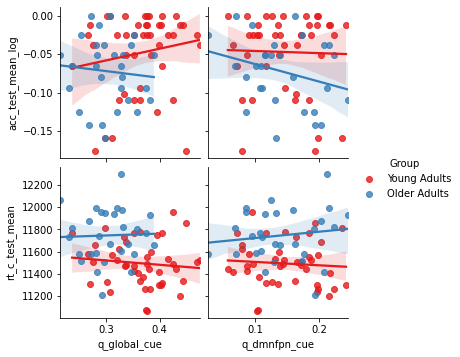

In [85]:
sns.set_palette('Set1')
modVars_ = [v for v in modVars if not 'power' in v and 'cue' in v]
sns.pairplot(data=df, y_vars=['acc_test_mean_log', 'rt_c_test_mean'], x_vars=modVars_, hue='Group', kind='reg')

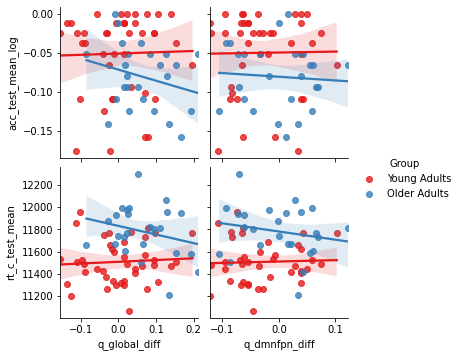

In [86]:
sns.set_palette('Set1')
modVars_ = [v for v in modVars if 'diff' in v]
sns.pairplot(data=df, x_vars=modVars_, y_vars=['acc_test_mean_log', 'rt_c_test_mean'], hue='Group', kind='reg')

### Participation coefficient

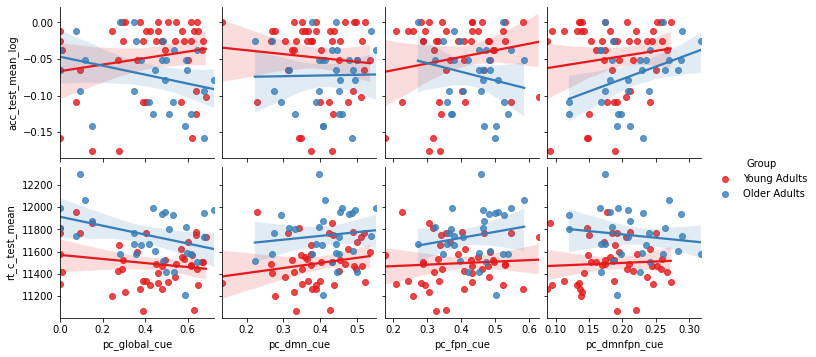

In [87]:
sns.set_palette('Set1')
pcVars_ = [v for v in pcVars if 'cue' in v and not 'power' in v]
sns.pairplot(data=df, y_vars=['acc_test_mean_log', 'rt_c_test_mean'], x_vars=pcVars_, hue='Group', kind='reg')

### Mean FC

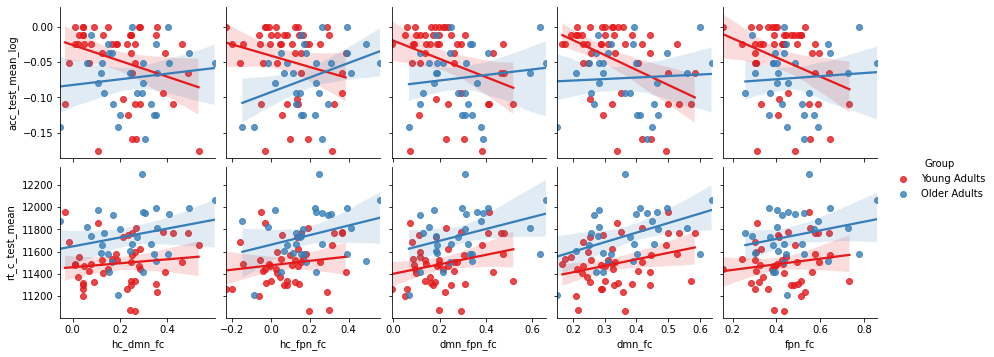

In [88]:
sns.set_palette('Set1')
sns.pairplot(data=df, y_vars=['acc_test_mean_log', 'rt_c_test_mean'], x_vars=fcVars, hue='Group', kind='reg')

### NBS Edge Strength

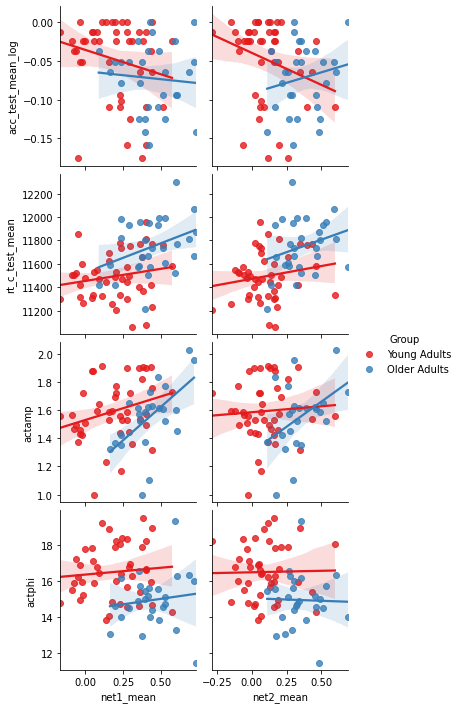

In [89]:
sns.set_palette('Set1')
sns.pairplot(data=df, y_vars=['acc_test_mean_log', 'rt_c_test_mean', 'actamp', 'actphi'], 
             x_vars=['net1_mean', 'net2_mean'], hue='Group', kind='reg')

## Exploratory 

In [90]:
regVars = ['rt_c_test_mean', 'net1_mean']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
print(len(regdf[regdf['net1_mean'].abs() > 3]))
regdf = regdf[regdf['net1_mean'].abs() < 3]
smf.ols(formula='rt_c_test_mean ~ net1_mean + Group', data=regdf).fit().summary()


0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_test_mean   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     14.86
Date:                Sun, 06 Mar 2022   Prob (F-statistic):           4.05e-06
Time:                        12:55:38   Log-Likelihood:                -92.060
No. Observations:                  74   AIC:                             190.1
Df Residuals:                      71   BIC:                             197.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.4338      0.180      2.410      0.019       0.075       0.793
Group[T.Young Adults]    -0.7134      0.247     -2.894      0.005      -1.205      -0.222
net1_mean                 0.2651      0.120      2.203      0.031       0.025       0.505
==============================================================================
Omnibus:                        0.170   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.918   Jarque-Bera (JB):                0.141
Skew:                          -0.097   Prob(JB):                        0.932
Kurtosis:                       2.911   Cond. No.                         3.71
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [91]:
regVars = ['acc_test_mean', 'net2_mean']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
print(len(regdf[regdf['net2_mean'].abs() > 3]))
regdf = regdf[regdf['net2_mean'].abs() < 3]
smf.ols(formula='acc_test_mean ~ net2_mean * Group', data=regdf).fit().summary()


0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          acc_test_mean   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     3.366
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0233
Time:                        12:55:38   Log-Likelihood:                -100.02
No. Observations:                  74   AIC:                             208.0
Df Residuals:                      70   BIC:                             217.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -0.4878      0.262     -1.859      0.067      -1.011       0.035
Group[T.Young Adults]               0.5194      0.311      1.671      0.099      -0.100       1.139
net2_mean                           0.2222      0.250      0.887      0.378      -0.277       0.722
net2_mean:Group[T.Young Adults]    -0.5714      0.304     -1.880      0.064      -1.178       0.035
==============================================================================
Omnibus:                        7.536   Durbin-Watson:                   1.883
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                7.725
Skew:                          -0.791   Prob(JB):                       0.0210
Kurtosis:                       2.943   Cond. No.                         5.88
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [92]:
regVars = ['rt_c_test_mean', 'net2_mean']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
print(len(regdf[regdf['net2_mean'].abs() > 3]))
regdf = regdf[regdf['net2_mean'].abs() < 3]
smf.ols(formula='rt_c_test_mean ~ net2_mean + Group', data=regdf).fit().summary()


0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_test_mean   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     13.86
Date:                Sun, 06 Mar 2022   Prob (F-statistic):           8.30e-06
Time:                        12:55:38   Log-Likelihood:                -92.808
No. Observations:                  74   AIC:                             191.6
Df Residuals:                      71   BIC:                             198.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.4400      0.188      2.336      0.022       0.064       0.815
Group[T.Young Adults]    -0.7235      0.262     -2.764      0.007      -1.245      -0.202
net2_mean                 0.2333      0.128      1.826      0.072      -0.021       0.488
==============================================================================
Omnibus:                        0.226   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.893   Jarque-Bera (JB):                0.244
Skew:                           0.123   Prob(JB):                        0.885
Kurtosis:                       2.864   Cond. No.                         3.93
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [93]:
regVars = ['net1_mean', 'actamp']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
print(len(regdf[regdf['actamp'].abs() > 3]))
print(len(regdf[regdf['net1_mean'].abs() > 3]))
regdf = regdf[regdf['actamp'].abs() < 3]
regdf = regdf[regdf['net1_mean'].abs() < 3]

smf.ols(formula='net1_mean ~ actamp + Group', data=regdf).fit().summary()

0
0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              net1_mean   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     22.86
Date:                Sun, 06 Mar 2022   Prob (F-statistic):           3.04e-08
Time:                        12:55:39   Log-Likelihood:                -78.379
No. Observations:                  68   AIC:                             162.8
Df Residuals:                      65   BIC:                             169.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.8009      0.160      4.994      0.000       0.481       1.121
Group[T.Young Adults]    -1.2377      0.200     -6.199      0.000      -1.636      -0.839
actamp                    0.3093      0.095      3.241      0.002       0.119       0.500
==============================================================================
Omnibus:                        2.058   Durbin-Watson:                   1.253
Prob(Omnibus):                  0.357   Jarque-Bera (JB):                1.372
Skew:                          -0.040   Prob(JB):                        0.504
Kurtosis:                       2.309   Cond. No.                         3.14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [94]:
regVars = ['net2_mean', 'actamp']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
print(len(regdf[regdf['actamp'].abs() > 3]))
print(len(regdf[regdf['net2_mean'].abs() > 3]))
regdf = regdf[regdf['actamp'].abs() < 3]
regdf = regdf[regdf['net2_mean'].abs() < 3]

smf.ols(formula='net2_mean ~ actamp', 
        data=regdf[regdf['Group'] == 'Older Adults']).fit().summary()

0
0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              net2_mean   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     4.990
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0360
Time:                        12:55:39   Log-Likelihood:                -23.324
No. Observations:                  24   AIC:                             50.65
Df Residuals:                      22   BIC:                             53.01
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8622      0.137      6.283      0.000       0.578       1.147
actamp         0.2882      0.129      2.234      0.036       0.021       0.556
==============================================================================
Omnibus:                        0.303   Durbin-Watson:                   2.317
Prob(Omnibus):                  0.859   Jarque-Bera (JB):                0.207
Skew:                           0.200   Prob(JB):                        0.902
Kurtosis:                       2.785   Cond. No.                         1.14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [95]:
df[['acc_test_mean', 'rt_c_test_mean'] + fcVars].corr()

,acc_test_mean,rt_c_test_mean,hc_dmn_fc,hc_fpn_fc,dmn_fpn_fc,dmn_fc,fpn_fc
acc_test_mean,1.000,-0.576,-0.195,-0.088,-0.207,-0.289,-0.202
rt_c_test_mean,-0.576,1.000,0.230,0.332,0.374,0.381,0.251
hc_dmn_fc,-0.195,0.230,1.000,0.756,0.593,0.571,0.544
hc_fpn_fc,-0.088,0.332,0.756,1.000,0.660,0.547,0.541
dmn_fpn_fc,-0.207,0.374,0.593,0.660,1.000,0.902,0.807
dmn_fc,-0.289,0.381,0.571,0.547,0.902,1.000,0.765
fpn_fc,-0.202,0.251,0.544,0.541,0.807,0.765,1.000


## RAR - Brain Associations

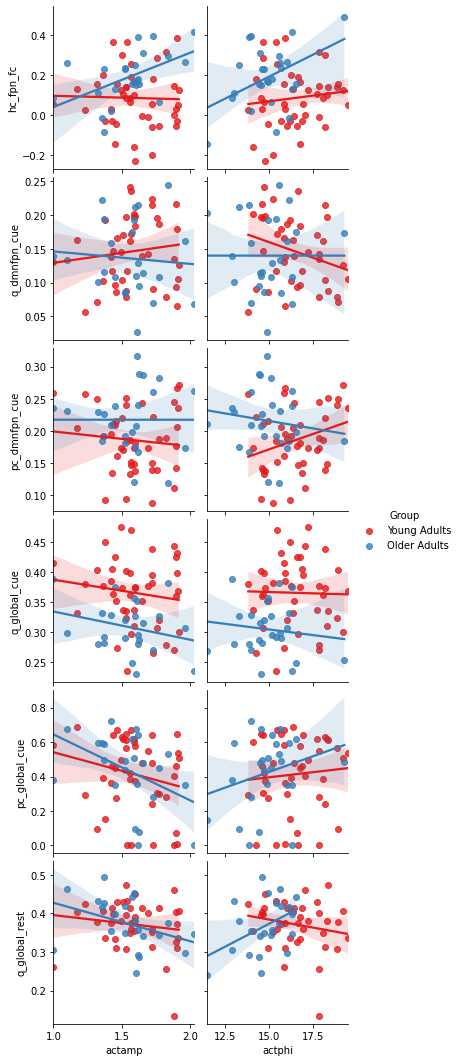

In [96]:
sns.set_palette('Set1')
sns.pairplot(data=df, x_vars=['actamp', 'actphi'],
             y_vars=['hc_fpn_fc', 'q_dmnfpn_cue', 'pc_dmnfpn_cue', 'q_global_cue', 'pc_global_cue', 'q_global_rest'], hue='Group', kind='reg')

In [97]:
regVars = ['q_global_rest', 'actamp']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
print(len(regdf[regdf['actamp'].abs() > 3]))
print(len(regdf[regdf['q_global_rest'].abs() > 3]))

regdf = regdf[regdf['q_global_rest'].abs() < 3]

smf.ols(formula='q_global_rest ~ actamp + Group', 
        data=regdf).fit().summary()




0
1


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          q_global_rest   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9585
Date:                Sun, 06 Mar 2022   Prob (F-statistic):              0.389
Time:                        12:55:45   Log-Likelihood:                -79.160
No. Observations:                  62   AIC:                             164.3
Df Residuals:                      59   BIC:                             170.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.0031      0.190      0.016      0.987      -0.378       0.384
Group[T.Young Adults]     0.0854      0.237      0.361      0.720      -0.389       0.559
actamp                   -0.1555      0.114     -1.362      0.178      -0.384       0.073
==============================================================================
Omnibus:                        1.711   Durbin-Watson:                   1.749
Prob(Omnibus):                  0.425   Jarque-Bera (JB):                1.482
Skew:                          -0.375   Prob(JB):                        0.477
Kurtosis:                       2.902   Cond. No.                         3.13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [98]:
regVars = ['q_global_rest', 'actphi']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
print(len(regdf[regdf['actphi'].abs() > 3]))
print(len(regdf[regdf['q_global_rest'].abs() > 3]))

regdf = regdf[regdf['q_global_rest'].abs() < 3]

smf.ols(formula='q_global_rest ~ actphi * Group', 
        data=regdf).fit().summary()



0
1


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          q_global_rest   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     2.473
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0704
Time:                        12:55:45   Log-Likelihood:                -78.477
No. Observations:                  63   AIC:                             165.0
Df Residuals:                      59   BIC:                             173.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.3813      0.245      1.557      0.125      -0.109       0.871
Group[T.Young Adults]           -0.2243      0.286     -0.783      0.437      -0.797       0.349
actphi                           0.5979      0.237      2.524      0.014       0.124       1.072
actphi:Group[T.Young Adults]    -0.7190      0.282     -2.553      0.013      -1.283      -0.155
==============================================================================
Omnibus:                        0.072   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.965   Jarque-Bera (JB):                0.075
Skew:                          -0.061   Prob(JB):                        0.963
Kurtosis:                       2.882   Cond. No.                         5.46
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [99]:
regVars = ['pc_global_cue', 'actphi']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

smf.ols(formula='pc_global_cue ~ actphi + Group', 
        data=regdf).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          pc_global_cue   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.7451
Date:                Sun, 06 Mar 2022   Prob (F-statistic):              0.479
Time:                        12:55:45   Log-Likelihood:                -98.556
No. Observations:                  70   AIC:                             203.1
Df Residuals:                      67   BIC:                             209.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.1277      0.214      0.598      0.552      -0.299       0.554
Group[T.Young Adults]    -0.2032      0.280     -0.725      0.471      -0.763       0.356
actphi                    0.1630      0.135      1.204      0.233      -0.107       0.433
==============================================================================
Omnibus:                        5.950   Durbin-Watson:                   1.800
Prob(Omnibus):                  0.051   Jarque-Bera (JB):                5.719
Skew:                          -0.643   Prob(JB):                       0.0573
Kurtosis:                       2.448   Cond. No.                         3.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [100]:
regVars = ['pc_global_cue', 'actamp']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

smf.ols(formula='pc_global_cue ~ actamp + Group', 
        data=regdf).fit().summary()




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          pc_global_cue   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     3.065
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0535
Time:                        12:55:45   Log-Likelihood:                -93.424
No. Observations:                  68   AIC:                             192.8
Df Residuals:                      65   BIC:                             199.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.0251      0.200      0.126      0.900      -0.375       0.425
Group[T.Young Adults]    -0.0388      0.249     -0.156      0.877      -0.536       0.459
actamp                   -0.2913      0.119     -2.447      0.017      -0.529      -0.054
==============================================================================
Omnibus:                        6.880   Durbin-Watson:                   1.824
Prob(Omnibus):                  0.032   Jarque-Bera (JB):                6.032
Skew:                          -0.643   Prob(JB):                       0.0490
Kurtosis:                       2.312   Cond. No.                         3.14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [101]:
regVars = ['q_global_cue', 'actamp']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

smf.ols(formula='q_global_cue ~ actamp + Group', 
        data=regdf).fit().summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           q_global_cue   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     10.31
Date:                Sun, 06 Mar 2022   Prob (F-statistic):           0.000129
Time:                        12:55:45   Log-Likelihood:                -87.119
No. Observations:                  68   AIC:                             180.2
Df Residuals:                      65   BIC:                             186.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.6501      0.182     -3.565      0.001      -1.014      -0.286
Group[T.Young Adults]     1.0047      0.227      4.425      0.000       0.551       1.458
actamp                   -0.1530      0.109     -1.410      0.163      -0.370       0.064
==============================================================================
Omnibus:                        0.177   Durbin-Watson:                   2.162
Prob(Omnibus):                  0.916   Jarque-Bera (JB):                0.354
Skew:                          -0.082   Prob(JB):                        0.838
Kurtosis:                       2.687   Cond. No.                         3.14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [102]:
regVars = ['pc_dmnfpn_cue', 'actphi']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

smf.ols(formula='pc_dmnfpn_cue ~ actphi * Group', 
        data=regdf).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          pc_dmnfpn_cue   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     3.620
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0175
Time:                        12:55:45   Log-Likelihood:                -93.994
No. Observations:                  70   AIC:                             196.0
Df Residuals:                      66   BIC:                             205.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.2877      0.225      1.278      0.206      -0.162       0.737
Group[T.Young Adults]           -0.6200      0.273     -2.273      0.026      -1.165      -0.075
actphi                          -0.1531      0.213     -0.720      0.474      -0.578       0.271
actphi:Group[T.Young Adults]     0.4676      0.266      1.757      0.084      -0.064       0.999
==============================================================================
Omnibus:                        0.830   Durbin-Watson:                   2.239
Prob(Omnibus):                  0.660   Jarque-Bera (JB):                0.829
Skew:                           0.037   Prob(JB):                        0.661
Kurtosis:                       2.472   Cond. No.                         4.59
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [103]:
regVars = ['hc_fpn_fc', 'actphi']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

smf.ols(formula='hc_fpn_fc ~ actphi + Group', 
        data=regdf).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              hc_fpn_fc   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     6.106
Date:                Sun, 06 Mar 2022   Prob (F-statistic):            0.00366
Time:                        12:55:45   Log-Likelihood:                -93.466
No. Observations:                  70   AIC:                             192.9
Df Residuals:                      67   BIC:                             199.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.5674      0.199      2.856      0.006       0.171       0.964
Group[T.Young Adults]    -0.9026      0.261     -3.463      0.001      -1.423      -0.382
actphi                    0.2495      0.126      1.981      0.052      -0.002       0.501
==============================================================================
Omnibus:                        0.542   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.762   Jarque-Bera (JB):                0.633
Skew:                           0.194   Prob(JB):                        0.729
Kurtosis:                       2.743   Cond. No.                         3.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [104]:
regVars = ['hc_fpn_fc', 'actphi']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

smf.ols(formula='hc_fpn_fc ~ actphi + Group', 
        data=regdf[regdf['Group'] == 'Older Adults']).fit().summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              hc_fpn_fc   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     5.575
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0267
Time:                        12:55:45   Log-Likelihood:                -33.096
No. Observations:                  26   AIC:                             70.19
Df Residuals:                      24   BIC:                             72.71
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6988      0.212      3.295      0.003       0.261       1.137
actphi         0.4733      0.200      2.361      0.027       0.060       0.887
==============================================================================
Omnibus:                        0.377   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.828   Jarque-Bera (JB):                0.242
Skew:                          -0.218   Prob(JB):                        0.886
Kurtosis:                       2.820   Cond. No.                         1.88
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [105]:
regVars = ['hc_fpn_fc', 'actamp']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

smf.ols(formula='hc_fpn_fc ~ actamp * Group', 
        data=regdf).fit().summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              hc_fpn_fc   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     4.750
Date:                Sun, 06 Mar 2022   Prob (F-statistic):            0.00471
Time:                        12:55:45   Log-Likelihood:                -89.652
No. Observations:                  68   AIC:                             187.3
Df Residuals:                      64   BIC:                             196.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.5116      0.192      2.671      0.010       0.129       0.894
Group[T.Young Adults]           -0.7621      0.238     -3.205      0.002      -1.237      -0.287
actamp                           0.4059      0.180      2.254      0.028       0.046       0.766
actamp:Group[T.Young Adults]    -0.4335      0.232     -1.869      0.066      -0.897       0.030
==============================================================================
Omnibus:                        0.101   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.951   Jarque-Bera (JB):                0.048
Skew:                           0.055   Prob(JB):                        0.976
Kurtosis:                       2.932   Cond. No.                         3.26
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [106]:
regVars = ['hc_fpn_fc', 'actamp']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

smf.ols(formula='hc_fpn_fc ~ actamp + Group', 
        data=regdf[regdf['Group'] == 'Older Adults']).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              hc_fpn_fc   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     7.681
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0111
Time:                        12:55:45   Log-Likelihood:                -26.369
No. Observations:                  24   AIC:                             56.74
Df Residuals:                      22   BIC:                             59.09
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5116      0.156      3.284      0.003       0.188       0.835
actamp         0.4059      0.146      2.771      0.011       0.102       0.710
==============================================================================
Omnibus:                        0.127   Durbin-Watson:                   2.289
Prob(Omnibus):                  0.939   Jarque-Bera (JB):                0.231
Skew:                          -0.148   Prob(JB):                        0.891
Kurtosis:                       2.621   Cond. No.                         1.14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

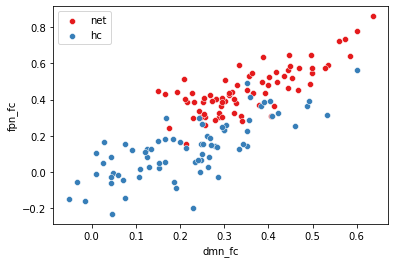

In [107]:
sns.scatterplot(data=df, x='dmn_fc', y='fpn_fc', label='net')
sns.scatterplot(data=df, x='hc_dmn_fc', y='hc_fpn_fc', label='hc')
plt.legend()

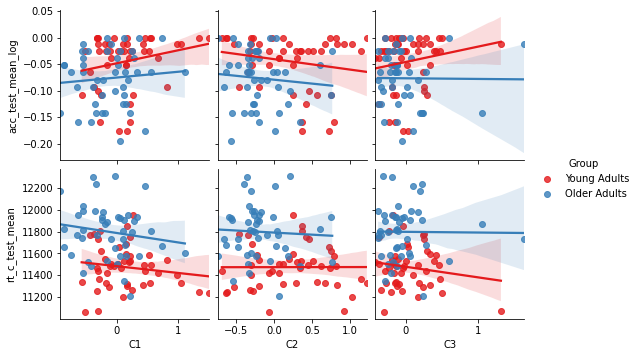

In [125]:
sns.pairplot(data=df, y_vars=['acc_test_mean_log', 'rt_c_test_mean'],
            x_vars=pcaVars, hue='Group', kind='reg')

### Mediation

In [108]:
medtab = pg.mediation_analysis(data=df, x='actamp', 
                               m='dmn_fc', 
                               y='acc_test_mean_log', 
                               covar='GroupBin', 
                               alpha=0.05)
# medtab.to_latex('./results/mediation_global.tex')
medtab

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,dmn_fc ~ X,0.120,0.059,0.046,0.002,0.237,Yes
1,Y ~ dmn_fc,-0.112,0.054,0.044,-0.220,-0.003,Yes
2,Total,0.042,0.027,0.128,-0.012,0.095,No
3,Direct,0.058,0.027,0.032,0.005,0.112,Yes
4,Indirect,-0.017,0.013,0.080,-0.049,0.002,No


## Plots

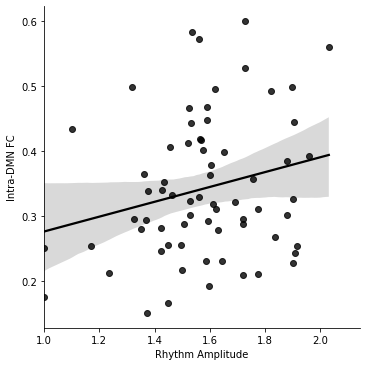

In [109]:
sns.lmplot(data=df, x='actamp', y='dmn_fc',
             scatter_kws={'color': 'black'}, line_kws={'color': 'black'})
plt.xlabel('Rhythm Amplitude'); plt.ylabel('Intra-DMN FC')
plt.savefig('./results/amp_dmnfc.png', dpi=300)

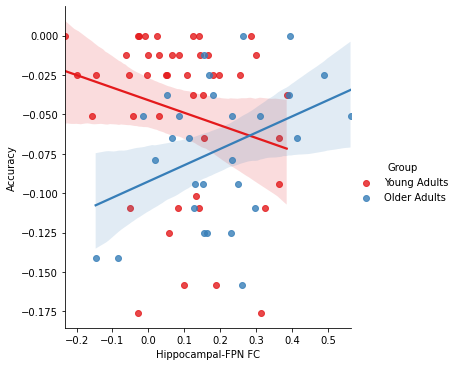

In [110]:
sns.lmplot(data=df, x='hc_fpn_fc', y='acc_test_mean_log', hue='Group')
plt.ylabel('Accuracy'); plt.xlabel('Hippocampal-FPN FC')
plt.savefig('./results/hcfpnfc_acc.png', dpi=300)

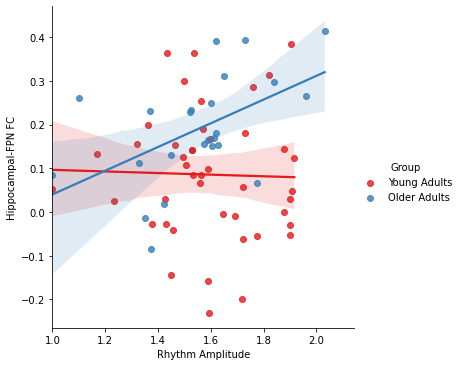

In [111]:
sns.lmplot(data=df, x='actamp', y='hc_fpn_fc', hue='Group')
plt.xlabel('Rhythm Amplitude'); plt.ylabel('Hippocampal-FPN FC')
plt.savefig('./results/amp_hcfpnfc.png', dpi=300)

In [112]:
sns.color_palette('Set1')[1]

(0.21568627450980393, 0.49411764705882355, 0.7215686274509804)

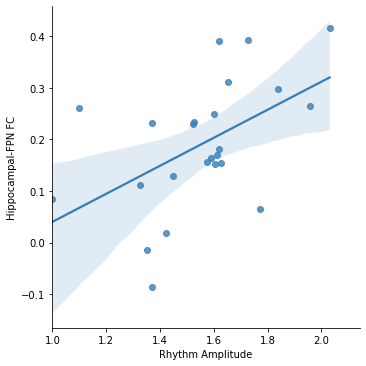

In [113]:
sns.lmplot(data=df[df['Group'] == 'Older Adults'], x='actamp', y='hc_fpn_fc', scatter_kws={'color': sns.color_palette('Set1')[1]}, line_kws={'color': sns.color_palette('Set1')[1]})
plt.xlabel('Rhythm Amplitude'); plt.ylabel('Hippocampal-FPN FC')
plt.savefig('./results/amp_hcfpnfc_oa.png', dpi=300)

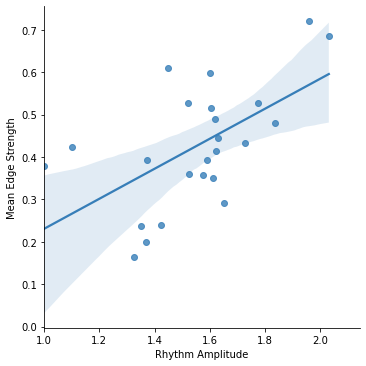

In [114]:
sns.lmplot(data=df[df['Group'] == 'Older Adults'], x='actamp', y='net1_mean', 
           scatter_kws={'color': sns.color_palette('Set1')[1]}, line_kws={'color': sns.color_palette('Set1')[1]})
plt.xlabel('Rhythm Amplitude'); plt.ylabel('Mean Edge Strength')
plt.savefig('./results/amp_net1mean_oa.png', dpi=300)

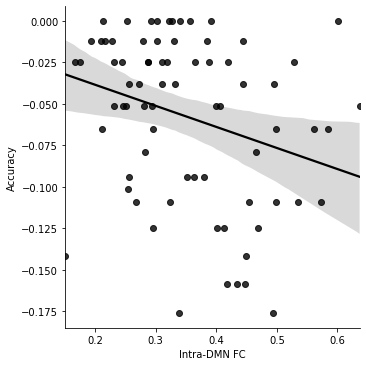

In [115]:
sns.lmplot(data=df, x='dmn_fc', y='acc_test_mean_log',
          scatter_kws={'color': 'black'}, line_kws={'color': 'black'})
plt.xlabel('Intra-DMN FC'); plt.ylabel('Accuracy')
plt.savefig('./results/dmn_acc.png', dpi=300)

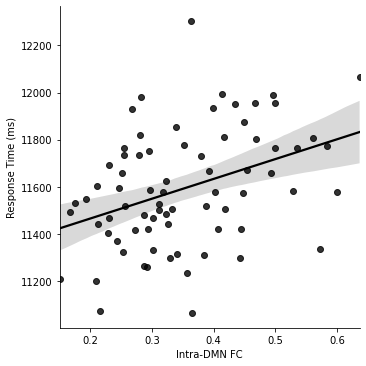

In [116]:
sns.lmplot(data=df, x='dmn_fc', y='rt_c_test_mean',
          scatter_kws={'color': 'black'}, line_kws={'color': 'black'})
plt.xlabel('Intra-DMN FC'); plt.ylabel('Response Time (ms)')
plt.savefig('./results/dmn_rtc.png', dpi=300)

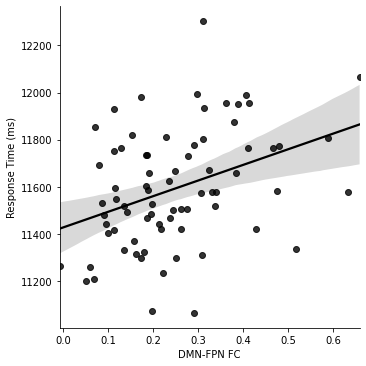

In [117]:
sns.lmplot(data=df, x='dmn_fpn_fc', y='rt_c_test_mean',
          scatter_kws={'color': 'black'}, line_kws={'color': 'black'})
plt.xlabel('DMN-FPN FC'); plt.ylabel('Response Time (ms)')
plt.savefig('./results/dmnfpn_rtc.png', dpi=300)

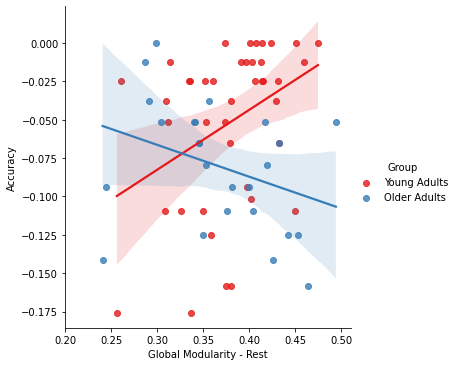

In [118]:
sns.lmplot(data=df[df['q_global_rest'] > 0.15], x='q_global_rest', y='acc_test_mean_log', hue='Group')
#           scatter_kws={'color': 'black'}, line_kws={'color': 'black'})
plt.xlabel('Global Modularity - Rest'); plt.ylabel('Accuracy'), plt.xlim([0.20, 0.51])
plt.savefig('./results/qglobalrest_acc.png', dpi=300)

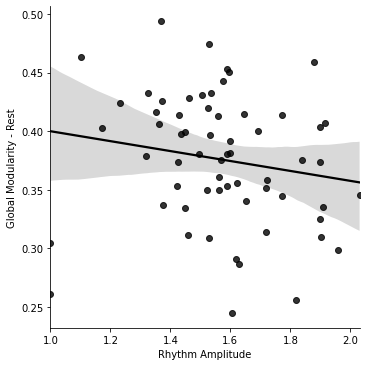

In [119]:
sns.lmplot(data=df[df['q_global_rest'] > 0.15], x='actamp', y='q_global_rest',
          scatter_kws={'color': 'black'}, line_kws={'color': 'black'})
plt.xlabel('Rhythm Amplitude'); plt.ylabel('Global Modularity - Rest')
plt.savefig('./results/amp_qglobalrest.png', dpi=300)

In [120]:
regVars = ['q_global_rest', 'actamp']

regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf = regdf[regdf['q_global_rest'].abs() < 3]

smf.ols(formula='q_global_rest ~ actamp', data=regdf).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          q_global_rest   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.813
Date:                Sun, 06 Mar 2022   Prob (F-statistic):              0.183
Time:                        12:55:58   Log-Likelihood:                -79.228
No. Observations:                  62   AIC:                             162.5
Df Residuals:                      60   BIC:                             166.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0583      0.112      0.520      0.605      -0.166       0.283
actamp        -0.1520      0.113     -1.347      0.183      -0.378       0.074
==============================================================================
Omnibus:                        1.892   Durbin-Watson:                   1.751
Prob(Omnibus):                  0.388   Jarque-Bera (JB):                1.669
Skew:                          -0.398   Prob(JB):                        0.434
Kurtosis:                       2.885   Cond. No.                         1.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [121]:
regVars = ['hc_fpn_fc', 'acc_test_mean_log']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

smf.ols(formula='acc_test_mean_log ~ Group * hc_fpn_fc', data=regdf).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_test_mean_log   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     3.594
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0177
Time:                        12:55:58   Log-Likelihood:                -99.701
No. Observations:                  74   AIC:                             207.4
Df Residuals:                      70   BIC:                             216.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -0.4282      0.191     -2.238      0.028      -0.810      -0.047
Group[T.Young Adults]               0.5539      0.242      2.290      0.025       0.071       1.036
hc_fpn_fc                           0.3328      0.179      1.855      0.068      -0.025       0.691
Group[T.Young Adults]:hc_fpn_fc    -0.5902      0.237     -2.489      0.015      -1.063      -0.117
==============================================================================
Omnibus:                       10.330   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.784
Skew:                          -0.928   Prob(JB):                      0.00455
Kurtosis:                       3.237   Cond. No.                         3.68
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Old Plot Code

In [122]:
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
# from scipy.stats.mstats import zscore

# testvar = 'hc_fpn_fc:Group[T.Young Adults]'
# plot_title = 'HC-FPN FC'
# x_pos = .5
# y_pos = -3.4

# model = smf.ols(formula='acc_test_mean_log ~ hc_fpn_fc * Group', data=df[abs(df['hc_fpn_fc']) < 3]).fit()
# summary = model.summary()

# #df = df.drop('40750')
# plt.figure(figsize=(8, 6), dpi=300)
# sns.lmplot(data=df[abs(df['hc_fpn_fc']) < 3], x='hc_fpn_fc', y="acc_test_mean_log", hue='Group', palette = 'Set1', legend_out=False)
# plt.ylabel('log(Accuracy)'); plt.xlabel('Mean HC-DMN FC')

# if model.pvalues[testvar] < 0.001:
#     plt.text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), ha='center')
#     print('\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]))
# else:
#     plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)
#     print('\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]))

# # plt.title('Paracingulate Gyrus - Frontal Orbital Cortex')
# plt.savefig(results_dir + 'scatter-hc-dmn-fc_accuracy.png', dpi=300, bbox_inches="tight")

# summary